In [1]:
import json
import re
import sqlite3
from sqlite3 import Connection

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def analyze_graph(g: ig.Graph):
    order = g.vcount()
    size = g.ecount()
    components = g.components()
    no_components = len(components)
    size_of_largest_component = max([len(component) for component in components])
    density = g.density()
    transitivity = g.transitivity_avglocal_undirected()
    
    print(f"Order: {order}")
    print(f"Size: {size}")
    print(f"No .of Components: {no_components}")
    print(f"Size of largest component: {size_of_largest_component}")
    print(f"Density: {density}")
    print(f"Transitivity: {transitivity}")
    
    degree_dist = g.degree()
    degree_counts = np.bincount(degree_dist)
    degrees = np.arange(len(degree_counts))
    
    non_zero = degree_counts > 0
    degrees = degrees[non_zero]
    degree_counts = degree_counts[non_zero]
    
    plt.figure(figsize=(8, 6))
    plt.loglog(degrees, degree_counts, marker="o", linestyle="", markersize=6, alpha=0.7, label="Degree Distribution")
    plt.title("Degree Distribution (Log-Log Scale)")
    plt.xlabel("Degree (log)")
    plt.ylabel("Frequency (log)")
    plt.grid(which="both", linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

In [4]:
def prepare_graph(g: ig.Graph):
    layout = g.layout("fr") # circle
    
    g.vs["color"] = "red"
    g.vs["size"] = 1
    g.vs["frame_width"] = 0
    g.vs["label"] = None
    
    g.es["color"] = "rgba(0, 0, 0, 0.1)"
    g.es["width"] = 0.5
    
    return g, layout

In [5]:
def plot_graph(g: ig.Graph, layout: ig.Layout, target_file = None):
    visual_style = {
        "layout": layout,
        "vertex_color": g.vs["color"],
        "vertex_size": g.vs["size"],
        "vertex_frame_width": 0,
        "vertex_label": None,
        "edge_color": g.es["color"],
        "edge_width": g.es["width"],
        # "bbox": (800, 800),  # Image size in pixels
        "margin": 2,
    }

    # Use matplotlib as the engine for visualization
    plt.figure(figsize=(10, 10))
    ig_plot = ig.plot(g, target=target_file, **visual_style, backend="matplotlib")

    if target_file is None:
        plt.show()  # Show plot interactively
    else:
        print(f"Plot saved to: {target_file}")

In [2]:
ideo_df = pd.read_csv("D:/UU/Sem3/SDM/social_data_mining/data/df_ideology_connections_s60.csv")
ideo_df[["author1", "author2"]] = ideo_df[["author1", "author2"]].astype(str)
print(ideo_df.dtypes)

Unnamed: 0        int64
id1               int64
id2               int64
url              object
text1            object
text2            object
lang1            object
lang2            object
author1          object
author2          object
time1            object
time2            object
seconds_diff    float64
dtype: object


In [6]:
authors = set(ideo_df["author1"])
authors.update(ideo_df["author2"])
authors = list(authors)
print(authors)
print(len(authors))

['108387763', '612892616', '1273725474', '34286774', '2379517662', '2290499112', '416201441', '4227354647', '258095379', '360122194', '3907652422', '74989387', '2290936952', '16467789', '20252263', '1118820366', '1407062449', '104927840', '1192340720', '531613271', '48614705', '359890944', '534589739', '98058623', '534008020', '2415494318', '378463656', '7682502', '501817216', '3004193357', '222323499', '227171006', '3099111852', '58514619', '90454250', '136158139', '339771436', '61260912', '547258560', '364797487', '2608508492', '1327843160', '387348297', '512766985', '368562186', '6021882', '267161986', '845297858', '21927949', '636496684', '74455664', '2173765655', '4220184639', '58576988', '235758913', '1115904920', '946371325', '177663215', '467963704', '353306975', '459450110', '512534801', '74903828', '449062421', '354212198', '383284040', '309172469', '456136508', '310833976', '2549969641', '19767466', '3190637849', '192590502', '357699181', '1459209162', '561771032', '24456529

In [8]:
r = 2
df_interactions = ideo_df.groupby(["author1", "author2", "lang1", "url"]).size().reset_index(name="count")
df_interactions = df_interactions[df_interactions["count"] >= r]
print(df_interactions.head(10))
print(df_interactions.info())
print(df_interactions.describe())

       author1     author2 lang1  \
76    10012122   168672457    es   
92   100224281  2359672154    es   
463  100731315   130982935    es   
467  100731315   138038293    es   
468  100731315   139826885    es   
478  100731315   169496608    es   
493  100731315   228741506    es   
494  100731315  2308232338    es   
496  100731315  2409546961    es   
507  100731315  2800175242    es   

                                                   url  count  
76   https://twitter.com/bbcmundo/status/6717567151...      9  
92                               http://bit.ly/1TnnCJa      2  
463      https://support.twitter.com/articles/20169222      2  
467      https://support.twitter.com/articles/20169222      2  
468      https://support.twitter.com/articles/20169222      2  
478      https://support.twitter.com/articles/20169222      2  
493      https://support.twitter.com/articles/20169222      2  
494      https://support.twitter.com/articles/20169222      2  
496      https://support.tw

In [9]:
ideo_graph = ig.Graph(n=len(authors))
ideo_graph["title"] = "Possible Ideology Network"
ideo_graph.vs["name"] = authors
ideo_graph.vs["text1"] = ideo_df["text1"]
ideo_graph.vs["text2"] = ideo_df["text2"]
ideo_graph.vs["url"] = ideo_df["url"]
ideo_graph.add_edges(df_interactions[["author1", "author2"]].apply(tuple, axis=1).tolist())
ideo_graph.delete_vertices([v.index for v in ideo_graph.vs if v.degree() < 1])
ideo_graph.summary()

'IGRAPH UN-- 892 2103 -- \n+ attr: title (g), name (v), text1 (v), text2 (v), url (v)'

Order: 892
Size: 2103
No .of Components: 212
Size of largest component: 115
Density: 0.00529208376742009
Transitivity: 0.6188788173518159


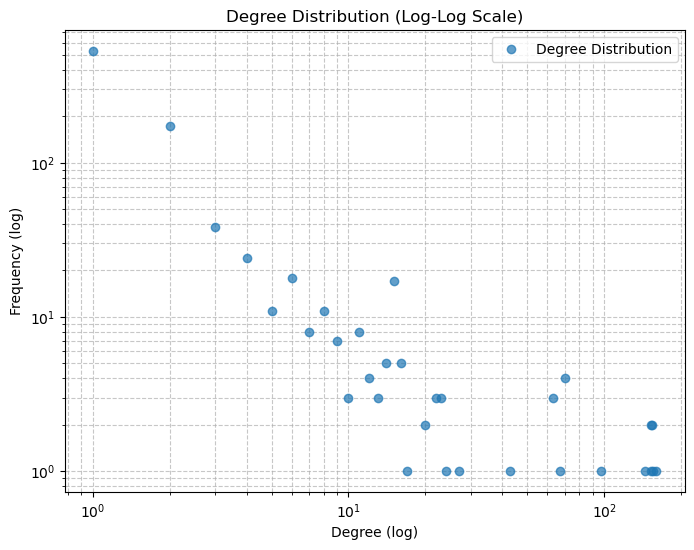

In [10]:
ideo_graph, ideo_layout = prepare_graph(ideo_graph)
analyze_graph(ideo_graph)

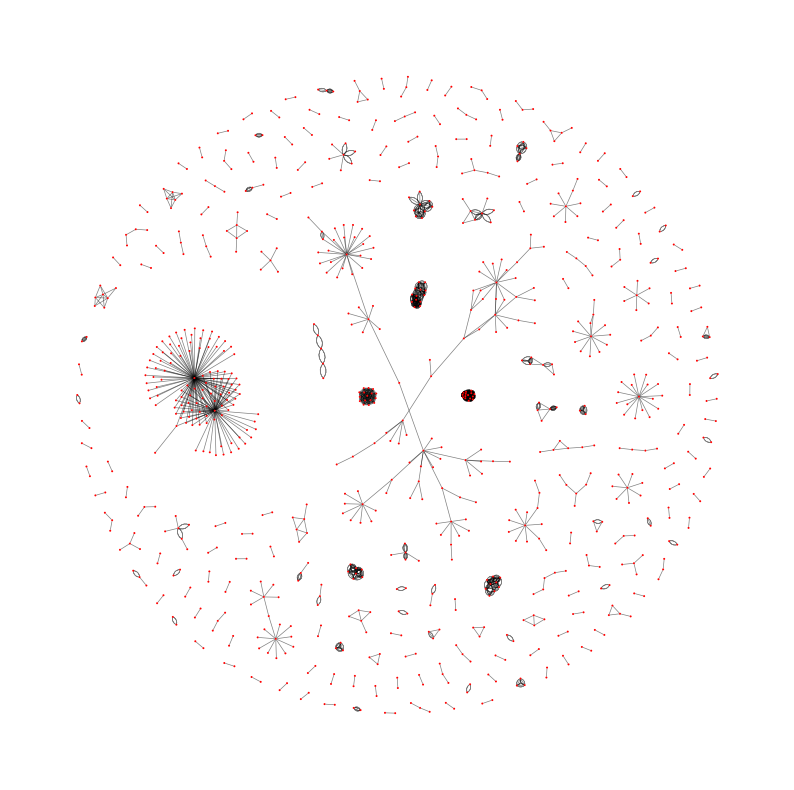

In [11]:
ideo_graph.vs["size"] = 2
ideo_graph.es["width"] = .5
ideo_graph.es["color"] = "rgba(1, 1, 1, .5)"
plot_graph(ideo_graph, layout=ideo_layout)

In [12]:
for component in ideo_graph.components():
    if len(component) > 100:
        print(f"Component len={len(component)}")
        for field in ideo_graph.vs[component]["text1"]:
            print(f"Field: {field}")

Component len=115
Field: BREAKING NEWS: #Cop21 Historic Climate Deal Reached: https://t.co/0S5DdymBzQ
#ParisAgreement  @Love_Trees https://t.co/rnt6N1Fzok
Field: #COP21 climate change summit reaches deal in #Paris 
Source: #BBC https://t.co/FmoozK2E2O
Field: Global climate change pact finally agreed at #COP21, committing all countries to cut carbon emissions for first time https://t.co/uiH0C30n9M
Field: World agrees landmark climate deal in Paris, committing all countries to cut emissions for first time #COP21  https://t.co/Xa0aAKQNpx
Field: #COP21 plenary LIVE @ https://t.co/YLbbJVKlaF #ParisAgreement @MAC_europa @EUClimateAction @AK_Itkonen #united4climate
Field: Religious Leaders Urge Climate Change Action at #COP21 https://t.co/8jPWZ5wJk8
Field: Lots of smiling faces in the plenary at #COP21. Big, friendly handshake between @JohnKerry and Xie Zhenhua. https://t.co/ePVLkvAOw9
Field: HAPPENING NOW- Final moments of #COP21 https://t.co/RcFQJLIXbZ
Field: Lot of smiling and hugging goin

communities: 3


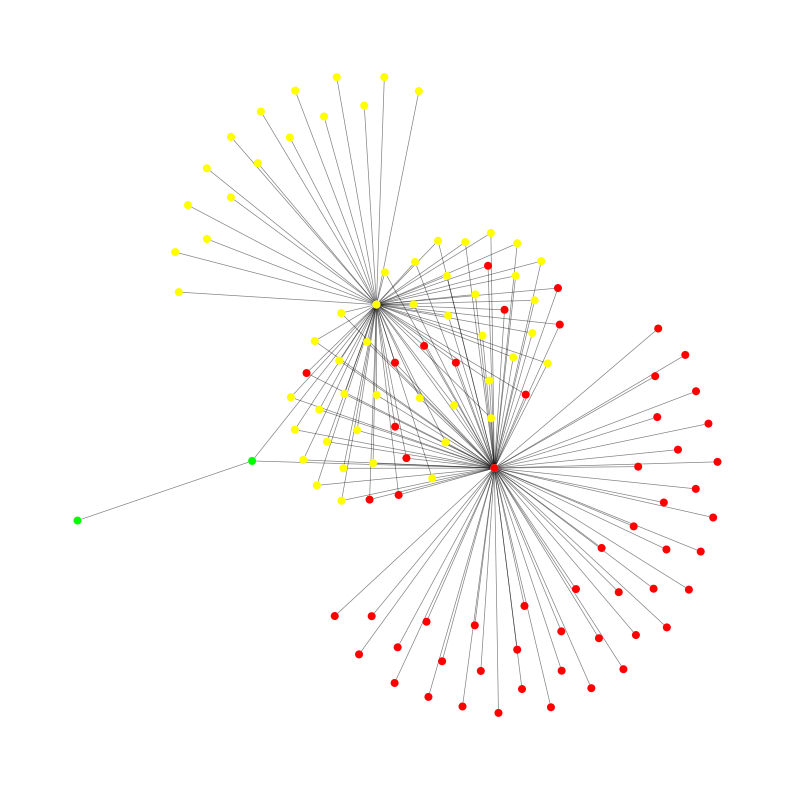

In [13]:
giant = ideo_graph.components().giant()
communities = giant.community_multilevel()
print(f"communities: {len(communities)}")
rainbow_colors = [
    "#FF0000",  # Red
    "#FFFF00",  # Yellow
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#8B00FF",  # Violet
    "#FF6347",  # Tomato
    "#40E0D0",  # Turquoise
    "#FFD700",  # Gold
    "#9ACD32",  # Yellow Green
    "#FF4500",  # Orange Red
    "#2E8B57",  # Sea Green
    "#9932CC",  # Dark Orchid
    "#FF1493",  # Deep Pink
    "#00FA9A",  # Medium Spring Green
    "#D2691E",  # Chocolate
    "#ADFF2F",  # Green Yellow
    "#8A2BE2",  # Blue Violet
    "#DC143C"   # Crimson
]
colors = [rainbow_colors[i] for i in ((communities.membership))]
plt.figure(figsize=(10,10))
# analyze_graph(giant)
ig.plot(giant,
        layout=giant.layout("fr"),
        vertex_color=colors,
        vertex_size=8,
        vertex_label=None,
        backend="matplotlib")

In [14]:
feature = "text1"
for i, community in enumerate(communities):
    print(f"Community {i}:")
    for vertex_id in community:
        vertex = giant.vs[vertex_id]
        
        feature_value = vertex[feature]
        print(f"  -  Vertex:{vertex_id}: {feature_value}")
    print("-" * 60)

Community 0:
  -  Vertex:0: BREAKING NEWS: #Cop21 Historic Climate Deal Reached: https://t.co/0S5DdymBzQ
#ParisAgreement  @Love_Trees https://t.co/rnt6N1Fzok
  -  Vertex:1: #COP21 climate change summit reaches deal in #Paris 
Source: #BBC https://t.co/FmoozK2E2O
  -  Vertex:2: Global climate change pact finally agreed at #COP21, committing all countries to cut carbon emissions for first time https://t.co/uiH0C30n9M
  -  Vertex:3: World agrees landmark climate deal in Paris, committing all countries to cut emissions for first time #COP21  https://t.co/Xa0aAKQNpx
  -  Vertex:4: #COP21 plenary LIVE @ https://t.co/YLbbJVKlaF #ParisAgreement @MAC_europa @EUClimateAction @AK_Itkonen #united4climate
  -  Vertex:5: Religious Leaders Urge Climate Change Action at #COP21 https://t.co/8jPWZ5wJk8
  -  Vertex:8: Lot of smiling and hugging going on - looks like the deal is in! #COP21 https://t.co/AAovDQ0tve
  -  Vertex:10: James Hansen, father of #climatechange awareness, calls Paris talks 'a fraud'